## GSK

In [1]:
# DataFrame
import numpy as np
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Collections
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
gsk_sent_df = pd.read_csv('../AvgDailySent/gsk_daily_avg_sent.csv')
gsk_sent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483 entries, 0 to 482
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   created_at  483 non-null    object 
 1   sentiment   440 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.7+ KB


In [3]:
gsk_sent_df.head()

,created_at,sentiment
0,2021-01-01 00:00:00+00:00,0.0
1,2021-01-02 00:00:00+00:00,1.0
2,2021-01-03 00:00:00+00:00,1.0
3,2021-01-04 00:00:00+00:00,1.0
4,2021-01-05 00:00:00+00:00,1.0


In [4]:
# Convert date column to datetime.
gsk_sent_df['created_at'] = pd.to_datetime(gsk_sent_df['created_at']).dt.tz_localize(None)
gsk_sent_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483 entries, 0 to 482
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   created_at  483 non-null    datetime64[ns]
 1   sentiment   440 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.7 KB


In [5]:
# Assign target value.
gsk_sent_df.loc[gsk_sent_df['sentiment'] < 1.0, 'sentiment'] = 0.0
gsk_sent_df.loc[gsk_sent_df['sentiment'] > 1.0, 'sentiment'] = 2.0
gsk_sent_df

,created_at,sentiment
0,2021-01-01,0.0
1,2021-01-02,1.0
2,2021-01-03,1.0
3,2021-01-04,1.0
4,2021-01-05,1.0
...,...,...
478,2022-04-24,2.0
479,2022-04-25,2.0
480,2022-04-26,2.0
481,2022-04-27,2.0


Text(0.5, 1.0, 'GSK daily sentiment labels distribuition')

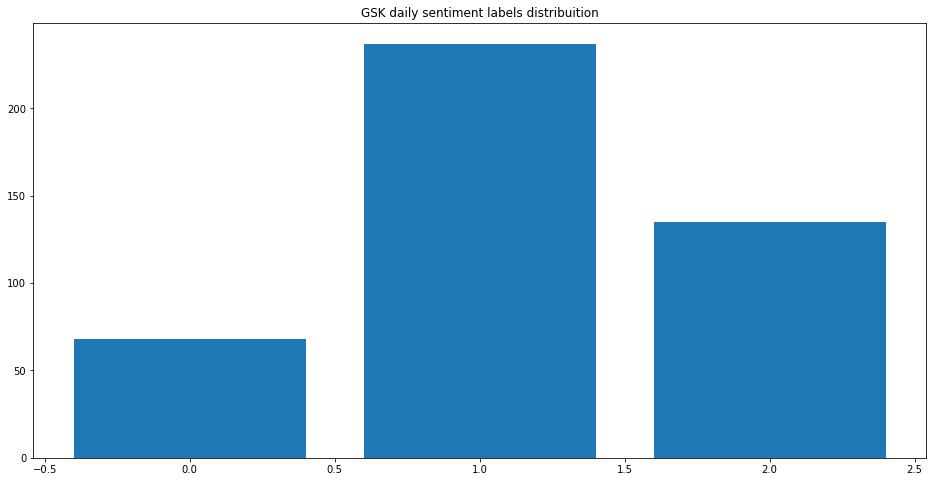

In [6]:
target_count = Counter(gsk_sent_df.sentiment)

plt.figure(figsize=(16,8))
plt.bar(target_count.keys(), target_count.values())
plt.title("GSK daily sentiment labels distribuition")

In [7]:
gsk_sent_df['sentiment'].value_counts()    

1.0    237
2.0    135
0.0     68
Name: sentiment, dtype: int64

### Load stock data

In [8]:
gsk_stock_df = pd.read_csv('../StockData/gsk.L.csv')
gsk_stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,1368.193237,1399.355835,1367.387329,1386.124146,1241.061890,7177382
1,2021-01-05,1390.355103,1396.399292,1378.871216,1385.519775,1240.520752,7017267
2,2021-01-06,1385.116821,1433.469971,1374.640259,1418.762573,1270.284546,12970994
3,2021-01-07,1457.243652,1457.243652,1398.816895,1408.286133,1260.904419,8396925
4,2021-01-08,1410.905151,1418.762573,1396.600708,1418.762573,1270.284546,7395204


In [9]:
gsk_stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335 entries, 0 to 334
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       335 non-null    object 
 1   Open       335 non-null    float64
 2   High       335 non-null    float64
 3   Low        335 non-null    float64
 4   Close      335 non-null    float64
 5   Adj Close  335 non-null    float64
 6   Volume     335 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 18.4+ KB


In [10]:
# Finetune the date such that sentiment for the previous day is assigned to the stock price of the current day.
gsk_sent_df['created_at'] = gsk_sent_df['created_at'] + pd.Timedelta(days=1)

# Rename the Date column to match the col_name in the sent_df.
gsk_stock_df = gsk_stock_df.rename({'Date': 'created_at'}, axis=1)
gsk_stock_df['created_at'] = pd.to_datetime(gsk_stock_df['created_at']).dt.tz_localize(None)

# Merge the two dataframes.
merged = pd.merge(gsk_stock_df, gsk_sent_df, on='created_at')
merged.head()

,created_at,Open,High,Low,Close,Adj Close,Volume,sentiment
0,2021-01-04,1368.193237,1399.355835,1367.387329,1386.124146,1241.061890,7177382,1.0
1,2021-01-05,1390.355103,1396.399292,1378.871216,1385.519775,1240.520752,7017267,1.0
2,2021-01-06,1385.116821,1433.469971,1374.640259,1418.762573,1270.284546,12970994,1.0
3,2021-01-07,1457.243652,1457.243652,1398.816895,1408.286133,1260.904419,8396925,1.0
4,2021-01-08,1410.905151,1418.762573,1396.600708,1418.762573,1270.284546,7395204,0.0


In [11]:
merged['sentiment'].value_counts()

1.0    165
2.0     92
0.0     48
Name: sentiment, dtype: int64

In [ ]:
merged.info()

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

In [13]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(merged[['sentiment']])
merged['sentiment'] = imputer.transform(merged[['sentiment']])
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335 entries, 0 to 334
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   created_at  335 non-null    datetime64[ns]
 1   Open        335 non-null    float64       
 2   High        335 non-null    float64       
 3   Low         335 non-null    float64       
 4   Close       335 non-null    float64       
 5   Adj Close   335 non-null    float64       
 6   Volume      335 non-null    int64         
 7   sentiment   335 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 23.6 KB


In [14]:
merged['sentiment'].value_counts()

1.0    195
2.0     92
0.0     48
Name: sentiment, dtype: int64

In [15]:
merged['trend'] = merged['Close'] - merged['Open']
merged.head()

,created_at,Open,High,Low,Close,Adj Close,Volume,sentiment,trend
0,2021-01-04,1368.193237,1399.355835,1367.387329,1386.124146,1241.061890,7177382,1.0,17.930909
1,2021-01-05,1390.355103,1396.399292,1378.871216,1385.519775,1240.520752,7017267,1.0,-4.835328
2,2021-01-06,1385.116821,1433.469971,1374.640259,1418.762573,1270.284546,12970994,1.0,33.645752
3,2021-01-07,1457.243652,1457.243652,1398.816895,1408.286133,1260.904419,8396925,1.0,-48.957519
4,2021-01-08,1410.905151,1418.762573,1396.600708,1418.762573,1270.284546,7395204,0.0,7.857422


In [16]:
merged.loc[merged['trend'] < 0, 'Trend'] = 'Negative'
merged.loc[merged['trend'] > 0, 'Trend'] = 'Positive'
merged.loc[merged['trend'] == 0, 'Trend'] = 'Neutral'
merged.head()

,created_at,Open,High,Low,Close,Adj Close,Volume,sentiment,trend,Trend
0,2021-01-04,1368.193237,1399.355835,1367.387329,1386.124146,1241.061890,7177382,1.0,17.930909,Positive
1,2021-01-05,1390.355103,1396.399292,1378.871216,1385.519775,1240.520752,7017267,1.0,-4.835328,Negative
2,2021-01-06,1385.116821,1433.469971,1374.640259,1418.762573,1270.284546,12970994,1.0,33.645752,Positive
3,2021-01-07,1457.243652,1457.243652,1398.816895,1408.286133,1260.904419,8396925,1.0,-48.957519,Negative
4,2021-01-08,1410.905151,1418.762573,1396.600708,1418.762573,1270.284546,7395204,0.0,7.857422,Positive


In [17]:
merged['Trend'].value_counts()

Positive    189
Negative    143
Neutral       3
Name: Trend, dtype: int64

In [18]:
merged.drop(['trend'], axis=1, inplace=True)
merged.rename({'Trend': 'trend'}, axis=1, inplace=True)
merged.head()

,created_at,Open,High,Low,Close,Adj Close,Volume,sentiment,trend
0,2021-01-04,1368.193237,1399.355835,1367.387329,1386.124146,1241.061890,7177382,1.0,Positive
1,2021-01-05,1390.355103,1396.399292,1378.871216,1385.519775,1240.520752,7017267,1.0,Negative
2,2021-01-06,1385.116821,1433.469971,1374.640259,1418.762573,1270.284546,12970994,1.0,Positive
3,2021-01-07,1457.243652,1457.243652,1398.816895,1408.286133,1260.904419,8396925,1.0,Negative
4,2021-01-08,1410.905151,1418.762573,1396.600708,1418.762573,1270.284546,7395204,0.0,Positive


In [19]:
future_trend = merged['Close'].diff(periods=5)
merged['future_trend'] = future_trend
merged.head(10)

,created_at,Open,High,Low,Close,Adj Close,Volume,sentiment,trend,future_trend
0,2021-01-04,1368.193237,1399.355835,1367.387329,1386.124146,1241.061890,7177382,1.0,Positive,NaN
1,2021-01-05,1390.355103,1396.399292,1378.871216,1385.519775,1240.520752,7017267,1.0,Negative,NaN
2,2021-01-06,1385.116821,1433.469971,1374.640259,1418.762573,1270.284546,12970994,1.0,Positive,NaN
3,2021-01-07,1457.243652,1457.243652,1398.816895,1408.286133,1260.904419,8396925,1.0,Negative,NaN
4,2021-01-08,1410.905151,1418.762573,1396.600708,1418.762573,1270.284546,7395204,0.0,Positive,NaN
5,2021-01-11,1415.538940,1423.396362,1401.033081,1405.264038,1258.198608,7629132,1.0,Negative,19.139892
6,2021-01-12,1405.666870,1409.293457,1377.057983,1377.057983,1232.944458,9750633,1.0,Negative,-8.461792
7,2021-01-13,1370.207886,1388.541870,1370.207886,1382.699219,1237.995483,12758771,1.0,Positive,-36.063354
8,2021-01-14,1380.684448,1406.875854,1375.446167,1403.652222,1256.755615,18404664,1.0,Positive,-4.633911
9,2021-01-15,1395.996338,1425.401123,1390.355103,1424.000854,1274.974731,8084203,1.0,Positive,5.238281


In [20]:
merged.loc[merged['future_trend'] < 0, 'Trend'] = 'Negative'
merged.loc[merged['future_trend'] > 0, 'Trend'] = 'Positive'
merged.loc[merged['future_trend'] == 0, 'Trend'] = 'Neutral'
merged.head(10)

,created_at,Open,High,Low,Close,Adj Close,Volume,sentiment,trend,future_trend,Trend
0,2021-01-04,1368.193237,1399.355835,1367.387329,1386.124146,1241.061890,7177382,1.0,Positive,NaN,NaN
1,2021-01-05,1390.355103,1396.399292,1378.871216,1385.519775,1240.520752,7017267,1.0,Negative,NaN,NaN
2,2021-01-06,1385.116821,1433.469971,1374.640259,1418.762573,1270.284546,12970994,1.0,Positive,NaN,NaN
3,2021-01-07,1457.243652,1457.243652,1398.816895,1408.286133,1260.904419,8396925,1.0,Negative,NaN,NaN
4,2021-01-08,1410.905151,1418.762573,1396.600708,1418.762573,1270.284546,7395204,0.0,Positive,NaN,NaN
5,2021-01-11,1415.538940,1423.396362,1401.033081,1405.264038,1258.198608,7629132,1.0,Negative,19.139892,Positive
6,2021-01-12,1405.666870,1409.293457,1377.057983,1377.057983,1232.944458,9750633,1.0,Negative,-8.461792,Negative
7,2021-01-13,1370.207886,1388.541870,1370.207886,1382.699219,1237.995483,12758771,1.0,Positive,-36.063354,Negative
8,2021-01-14,1380.684448,1406.875854,1375.446167,1403.652222,1256.755615,18404664,1.0,Positive,-4.633911,Negative
9,2021-01-15,1395.996338,1425.401123,1390.355103,1424.000854,1274.974731,8084203,1.0,Positive,5.238281,Positive


In [21]:
merged.drop(['future_trend'], axis=1, inplace=True)
merged.rename({'Trend': 'future_trend'}, axis=1, inplace=True)

In [22]:
merged.head(10)

,created_at,Open,High,Low,Close,Adj Close,Volume,sentiment,trend,future_trend
0,2021-01-04,1368.193237,1399.355835,1367.387329,1386.124146,1241.061890,7177382,1.0,Positive,NaN
1,2021-01-05,1390.355103,1396.399292,1378.871216,1385.519775,1240.520752,7017267,1.0,Negative,NaN
2,2021-01-06,1385.116821,1433.469971,1374.640259,1418.762573,1270.284546,12970994,1.0,Positive,NaN
3,2021-01-07,1457.243652,1457.243652,1398.816895,1408.286133,1260.904419,8396925,1.0,Negative,NaN
4,2021-01-08,1410.905151,1418.762573,1396.600708,1418.762573,1270.284546,7395204,0.0,Positive,NaN
5,2021-01-11,1415.538940,1423.396362,1401.033081,1405.264038,1258.198608,7629132,1.0,Negative,Positive
6,2021-01-12,1405.666870,1409.293457,1377.057983,1377.057983,1232.944458,9750633,1.0,Negative,Negative
7,2021-01-13,1370.207886,1388.541870,1370.207886,1382.699219,1237.995483,12758771,1.0,Positive,Negative
8,2021-01-14,1380.684448,1406.875854,1375.446167,1403.652222,1256.755615,18404664,1.0,Positive,Negative
9,2021-01-15,1395.996338,1425.401123,1390.355103,1424.000854,1274.974731,8084203,1.0,Positive,Positive


### Moving Averages

In [23]:
sma_5 = merged['Close'].rolling(5).mean().shift()
ema_5 = merged['Close'].ewm(5).mean().shift()

In [24]:
merged['sma_5'] = sma_5
merged['ema_5'] = ema_5
merged.head(10)

,created_at,Open,High,Low,Close,Adj Close,Volume,sentiment,trend,future_trend,sma_5,ema_5
0,2021-01-04,1368.193237,1399.355835,1367.387329,1386.124146,1241.061890,7177382,1.0,Positive,NaN,NaN,NaN
1,2021-01-05,1390.355103,1396.399292,1378.871216,1385.519775,1240.520752,7017267,1.0,Negative,NaN,NaN,1386.124146
2,2021-01-06,1385.116821,1433.469971,1374.640259,1418.762573,1270.284546,12970994,1.0,Positive,NaN,NaN,1385.794489
3,2021-01-07,1457.243652,1457.243652,1398.816895,1408.286133,1260.904419,8396925,1.0,Negative,NaN,NaN,1398.836808
4,2021-01-08,1410.905151,1418.762573,1396.600708,1418.762573,1270.284546,7395204,0.0,Positive,NaN,NaN,1401.878618
5,2021-01-11,1415.538940,1423.396362,1401.033081,1405.264038,1258.198608,7629132,1.0,Negative,Positive,1403.491040,1406.583328
6,2021-01-12,1405.666870,1409.293457,1377.057983,1377.057983,1232.944458,9750633,1.0,Negative,Negative,1407.319018,1406.252729
7,2021-01-13,1370.207886,1388.541870,1370.207886,1382.699219,1237.995483,12758771,1.0,Positive,Negative,1405.626660,1399.503295
8,2021-01-14,1380.684448,1406.875854,1375.446167,1403.652222,1256.755615,18404664,1.0,Positive,Negative,1398.413989,1395.853878
9,2021-01-15,1395.996338,1425.401123,1390.355103,1424.000854,1274.974731,8084203,1.0,Positive,Positive,1397.487207,1397.466052


In [25]:
merged.dropna(inplace=True)
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330 entries, 5 to 334
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   created_at    330 non-null    datetime64[ns]
 1   Open          330 non-null    float64       
 2   High          330 non-null    float64       
 3   Low           330 non-null    float64       
 4   Close         330 non-null    float64       
 5   Adj Close     330 non-null    float64       
 6   Volume        330 non-null    int64         
 7   sentiment     330 non-null    float64       
 8   trend         330 non-null    object        
 9   future_trend  330 non-null    object        
 10  sma_5         330 non-null    float64       
 11  ema_5         330 non-null    float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(2)
memory usage: 33.5+ KB


In [26]:
merged.set_index('created_at', inplace=True)
merged.head(10)

,Open,High,Low,Close,Adj Close,Volume,sentiment,trend,future_trend,sma_5,ema_5
created_at,,,,,,,,,,,
2021-01-11,1415.538940,1423.396362,1401.033081,1405.264038,1258.198608,7629132,1.0,Negative,Positive,1403.491040,1406.583328
2021-01-12,1405.666870,1409.293457,1377.057983,1377.057983,1232.944458,9750633,1.0,Negative,Negative,1407.319018,1406.252729
2021-01-13,1370.207886,1388.541870,1370.207886,1382.699219,1237.995483,12758771,1.0,Positive,Negative,1405.626660,1399.503295
2021-01-14,1380.684448,1406.875854,1375.446167,1403.652222,1256.755615,18404664,1.0,Positive,Negative,1398.413989,1395.853878
2021-01-15,1395.996338,1425.401123,1390.355103,1424.000854,1274.974731,8084203,1.0,Positive,Positive,1397.487207,1397.466052
2021-01-18,1419.366943,1423.597900,1408.890503,1410.300781,1262.708252,7125364,1.0,Negative,Positive,1398.534863,1402.740347
2021-01-19,1414.733154,1426.619995,1410.099243,1420.777344,1272.088501,5537390,1.0,Positive,Positive,1399.542212,1404.196385
2021-01-20,1407.278687,1420.575806,1383.907959,1389.952148,1244.489380,12248899,2.0,Negative,Positive,1408.286084,1407.308976
2021-01-21,1374.841797,1397.406616,1373.741821,1374.841797,1230.960205,11800010,1.0,Neutral,Negative,1409.736670,1404.117923


Text(0.5, 1.0, 'GlaxoSmithKline Closing Stock Price and Moving Averages')

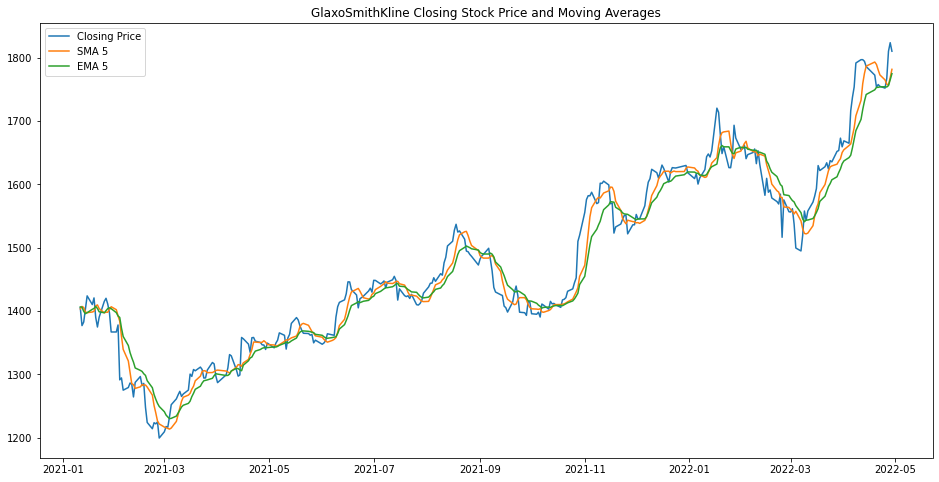

In [25]:
# Plot close price and moving averages.
plt.figure(figsize=(16,8))
plt.plot(merged['Close'], label='Closing Price')
plt.plot(merged['sma_5'], label='SMA 5')
plt.plot(merged['ema_5'], label='EMA 5')
plt.legend(loc='upper left')
plt.title('GlaxoSmithKline Closing Stock Price and Moving Averages')

In [27]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 330 entries, 2021-01-11 to 2022-04-29
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          330 non-null    float64
 1   High          330 non-null    float64
 2   Low           330 non-null    float64
 3   Close         330 non-null    float64
 4   Adj Close     330 non-null    float64
 5   Volume        330 non-null    int64  
 6   sentiment     330 non-null    float64
 7   trend         330 non-null    object 
 8   future_trend  330 non-null    object 
 9   sma_5         330 non-null    float64
 10  ema_5         330 non-null    float64
dtypes: float64(8), int64(1), object(2)
memory usage: 30.9+ KB


### Train - Test Split

In [28]:
test_size = 110
df_train = merged[:-test_size]
df_test = merged[-test_size:]
print('There are {} training samples and {} test samples.'.format(len(df_train), len(df_test)))

There are 220 training samples and 110 test samples.


In [29]:
def get_dummies(train_set, test_set, old_col_name):
    """Given a trainset, a testset, and the name of a column holding a 
    categorical variable, fit an encoder on the trainset, and use the 
    encoder to add dummy columns into the trainset and testset
    """
    
    one_hot_encoder = OneHotEncoder(drop="if_binary", sparse=False)
    
    cat_vals = train_set[old_col_name].values.reshape(-1,1)
    transformed = one_hot_encoder.fit_transform(cat_vals)
    
    new_col_names = one_hot_encoder.categories_[0].tolist()[1:]
    # Trainset 
    for i, new_col_name in enumerate(new_col_names):
        train_set[new_col_name] = transformed[:,i]
    
    cat_vals = test_set[old_col_name].values.reshape(-1,1)
    transformed = one_hot_encoder.transform(cat_vals)
    # Testset
    for i, new_col_name in enumerate(new_col_names):
        test_set[new_col_name] = transformed[:,i]
    
    return train_set, test_set

df_train, df_test = get_dummies(df_train, df_test, 'trend')

# check if the dummies are produced correctly in the trainset
df_train.head()

,Open,High,Low,Close,Adj Close,Volume,sentiment,trend,future_trend,sma_5,ema_5,Neutral,Positive
created_at,,,,,,,,,,,,,
2021-01-11,1415.538940,1423.396362,1401.033081,1405.264038,1258.198608,7629132,1.0,Negative,Positive,1403.491040,1406.583328,1.0,0.0
2021-01-12,1405.666870,1409.293457,1377.057983,1377.057983,1232.944458,9750633,1.0,Negative,Negative,1407.319018,1406.252729,1.0,0.0
2021-01-13,1370.207886,1388.541870,1370.207886,1382.699219,1237.995483,12758771,1.0,Positive,Negative,1405.626660,1399.503295,0.0,0.0
2021-01-14,1380.684448,1406.875854,1375.446167,1403.652222,1256.755615,18404664,1.0,Positive,Negative,1398.413989,1395.853878,0.0,0.0
2021-01-15,1395.996338,1425.401123,1390.355103,1424.000854,1274.974731,8084203,1.0,Positive,Positive,1397.487207,1397.466052,0.0,0.0


In [30]:
df_test.head()

,Open,High,Low,Close,Adj Close,Volume,sentiment,trend,future_trend,sma_5,ema_5,Neutral,Positive
created_at,,,,,,,,,,,,,
2021-11-22,1539.242554,1544.279419,1528.067993,1537.429321,1477.559937,4152901,2.0,Negative,Negative,1558.986792,1558.669626,1.0,0.0
2021-11-23,1532.593994,1553.345581,1519.901245,1544.682251,1484.530396,6007611,1.0,Positive,Negative,1546.656738,1555.129575,0.0,0.0
2021-11-24,1543.473511,1559.591187,1541.458740,1550.927856,1490.532837,5215441,1.0,Positive,Negative,1541.700537,1553.388355,0.0,0.0
2021-11-25,1551.330933,1556.166260,1544.879761,1551.330933,1490.920288,4574096,1.0,Neutral,Positive,1537.791968,1552.978271,0.0,1.0
2021-11-26,1523.124878,1538.033691,1514.058594,1521.916016,1462.650757,9356135,1.0,Negative,Negative,1543.433179,1552.703715,1.0,0.0


In [31]:
df_train.drop(['trend'], axis=1, inplace=True)
df_test.drop(['trend'], axis=1, inplace=True)

In [38]:
# df_train.rename({'Positive': 'encoded_trend'}, axis=1, inplace=True)
# df_test.rename({'Positive': 'encoded_trend'}, axis=1, inplace=True)

### Training set scaling

In [32]:
scaler = StandardScaler()

trainset_target = df_train["future_trend"].values
trainset_predictors = df_train.drop("future_trend", axis=1)
scaled_vals = scaler.fit_transform(trainset_predictors)
df_train = pd.DataFrame(scaled_vals, columns=trainset_predictors.columns)

# Put non-scaled target variable back into the dataframe
df_train['future_trend'] = trainset_target

# inspect the data
df_train.head()

,Open,High,Low,Close,Adj Close,Volume,sentiment,sma_5,ema_5,Neutral,Positive,future_trend
0,0.243205,0.192014,0.210609,0.109349,-0.379757,-0.248521,-0.119979,0.114636,0.194885,1.126073,-0.095783,Positive
1,0.128392,0.025256,-0.069017,-0.216844,-0.638936,0.217608,-0.119979,0.160537,0.190590,1.126073,-0.095783,Negative
2,-0.283999,-0.220119,-0.148912,-0.151605,-0.587098,0.878545,-0.119979,0.140244,0.102902,-0.888042,-0.095783,Negative
3,-0.162155,-0.003331,-0.087816,0.090709,-0.394566,2.119040,-0.119979,0.053757,0.055489,-0.888042,-0.095783,Negative
4,0.015923,0.215719,0.086070,0.326034,-0.207587,-0.148534,-0.119979,0.042644,0.076435,-0.888042,-0.095783,Positive


### Testing set scaling

In [33]:
testset_target = df_test["future_trend"].values
testset_predictors = df_test.drop("future_trend", axis=1)

# fit_transform returns a NumPy array, so we need to put it back 
# into a Pandas dataframe
scaled_vals = scaler.transform(testset_predictors)
df_test = pd.DataFrame(scaled_vals, columns=testset_predictors.columns)

# Put non-scaled target variable back into the dataframe
df_test['future_trend'] = testset_target

# inspect the data
df_test.head()

,Open,High,Low,Close,Adj Close,Volume,sentiment,sma_5,ema_5,Neutral,Positive,future_trend
0,1.681887,1.621379,1.692245,1.637797,1.871505,-1.012306,1.529732,1.979178,2.170768,1.126073,-0.095783,Negative
1,1.604564,1.728581,1.596994,1.721674,1.943041,-0.604796,-0.119979,1.831329,2.124777,-0.888042,-0.095783,Negative
2,1.731093,1.802431,1.848424,1.793903,2.004643,-0.778849,-0.119979,1.771899,2.102155,-0.888042,-0.095783,Negative
3,1.822476,1.761934,1.888324,1.798564,2.008619,-0.919763,-0.119979,1.725032,2.096827,-0.888042,10.440307,Positive
4,1.494437,1.547528,1.528850,1.458390,1.718495,0.130930,-0.119979,1.792675,2.093260,1.126073,-0.095783,Negative


In [34]:
X_train = df_train.drop('future_trend', axis=1)
y_train = df_train['future_trend'].copy()

### Baseline

In [35]:
y_train.value_counts()

Positive    124
Negative     95
Neutral       1
Name: future_trend, dtype: int64

The baseline classifier will output "Negative" for all predictions. We will use macro-averaging in this project (precision, recall and F-score are evaluated in each class separately and then averaged across classes).

So if we apply the baseline classifier to all of the training set. 

For the "Positive" label, the accuracy measures will be:

* Precision: 124/220 = 0.564

* Recall: 124/117 = 1.0

* F-score: 2/(1/precision + 1/recall) = 0.721

For the "Positive" label, it will be:

* Precision: 0.0/0.0 = 0.0

* Recall: 0.0/95 = 0.0

* F-score: 0.0

The averages of the two classes, i.e. the eventual baseline scores:

* **Precision: 0.188**

* **Recall: 0.333**

* **F-score: 0.241**

### Random Forest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier
import time

rf = RandomForestClassifier(random_state=7)

# specify the hyperparameters and their values
# 4 x 3 x 2 = 24 combinations in the grid
param_grid = {
    'n_estimators': [10, 100, 200, 1000],
    'max_depth': [3, 5, 15],
    'min_samples_split': [5, 10]
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=10,
                           scoring='accuracy', 
                           return_train_score=True) 

start = time.time()
grid_search.fit(X_train, y_train)
end = time.time() - start
print(f"Took {end} seconds")

Took 114.8177502155304 seconds


In [37]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=1000,
                       random_state=7)

In [38]:
grid_search.best_score_

0.5136363636363636

In [39]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
19,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 1000}",0.992424,0.513636,48.244275
16,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 10}",0.975253,0.500000,48.731227
18,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 200}",0.991919,0.490909,50.509165
17,"{'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 100}",0.993434,0.490909,50.584647
21,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 100}",0.970707,0.486364,49.895942
20,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 10}",0.946465,0.481818,49.092850
23,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 1000}",0.966667,0.481818,50.156740
22,"{'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}",0.967677,0.477273,50.678497
10,"{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 200}",0.934343,0.463636,50.378378
11,"{'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 1000}",0.939899,0.459091,51.155293


In [40]:
feature_importances = grid_search.best_estimator_.feature_importances_

for k, v in sorted(zip(feature_importances, X_train.columns), reverse=True):
    print(f"{v}: {k}")

ema_5: 0.17801584515772415
sma_5: 0.14401565688859294
Adj Close: 0.1390711316435448
Close: 0.1297018209285612
High: 0.10171483339855858
Low: 0.09834476032710258
Volume: 0.08603451155191302
Open: 0.08585833401379699
Neutral: 0.01981765621718742
sentiment: 0.01575919991584711
Positive: 0.001666249957171295


In [41]:
import os
from joblib import dump

# create a folder where all trained models will be kept
if not os.path.exists("models"):
    os.makedirs("models")
    
dump(grid_search.best_estimator_, 'models/gsk-rf-clf.joblib')

['models/gsk-rf-clf.joblib']

### Support Vector Classifier.

In [42]:
from sklearn.svm import SVC

svm = SVC(random_state=7, kernel='rbf')

# specify the hyperparameters and their values
# 5 x 3 = 15 combinations in the grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ["scale", "auto", 0.1],
}

# we'll use 10-fold cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=10,
                           scoring='accuracy', 
                           return_train_score=True) 

start = time.time()
grid_search.fit(X_train, y_train)
end = time.time() - start
print(f"Took {end} seconds")

Took 2.2229690551757812 seconds


In [43]:
grid_search.best_score_

0.7000000000000001

In [51]:
grid_search.best_estimator_

SVC(C=10, random_state=7)

In [44]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
13,"{'C': 100, 'gamma': 'auto'}",0.952020,0.700000,2.647215e+01
12,"{'C': 100, 'gamma': 'scale'}",0.951515,0.686364,2.786624e+01
10,"{'C': 10, 'gamma': 'auto'}",0.902525,0.681818,2.445439e+01
11,"{'C': 10, 'gamma': 0.1}",0.905556,0.677273,2.520915e+01
9,"{'C': 10, 'gamma': 'scale'}",0.904545,0.672727,2.562814e+01
14,"{'C': 100, 'gamma': 0.1}",0.955051,0.668182,3.003702e+01
6,"{'C': 1, 'gamma': 'scale'}",0.765152,0.613636,1.980198e+01
7,"{'C': 1, 'gamma': 'auto'}",0.764646,0.613636,1.974901e+01
8,"{'C': 1, 'gamma': 0.1}",0.770202,0.609091,2.091803e+01
0,"{'C': 0.01, 'gamma': 'scale'}",0.563636,0.563636,3.939501e-14


In [45]:
# Save the model
if not os.path.exists("models"):
    os.makedirs("models")
    
dump(grid_search.best_estimator_, 'models/gsk-svm-rbf-clf.joblib')

['models/gsk-svm-rbf-clf.joblib']

In [46]:
from joblib import load
best_svm = load("models/gsk-svm-rbf-clf.joblib")
best_rf = load("models/gsk-rf-clf.joblib")

In [47]:
X_test = df_test.drop("future_trend", axis=1)
y_test = df_test["future_trend"].copy()

In [48]:
ypred = best_svm.predict(X_test)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(y_test, ypred, average="macro")
print("SVM:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

SVM:
Precision: 0.7729411764705882
Recall: 0.6970108695652174
F score: 0.6984592116457132


In [49]:
accuracy_score(y_test, ypred)

0.7363636363636363

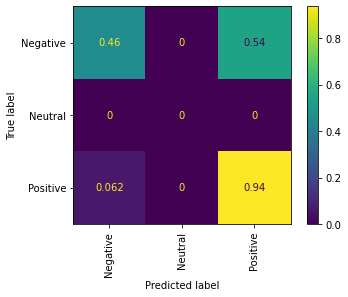

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, ypred, labels=best_svm.classes_, 
                                        xticks_rotation="vertical", normalize="true")

In [51]:
rf_ypred = best_rf.predict(X_test)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(y_test, rf_ypred, average="macro")
print("Random Forest:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

Random Forest:
Precision: 0.8137254901960784
Recall: 0.5869565217391304
F score: 0.533690316822847


In [52]:
accuracy_score(y_test, rf_ypred)

0.6545454545454545

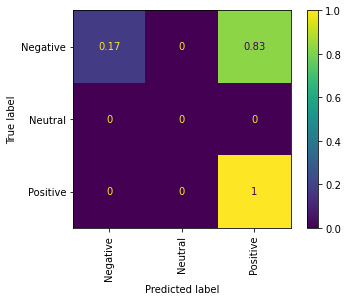

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, rf_ypred, labels=best_svm.classes_, 
                                        xticks_rotation="vertical", normalize="true")

### TSA

In [54]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [55]:
def stationary_plot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

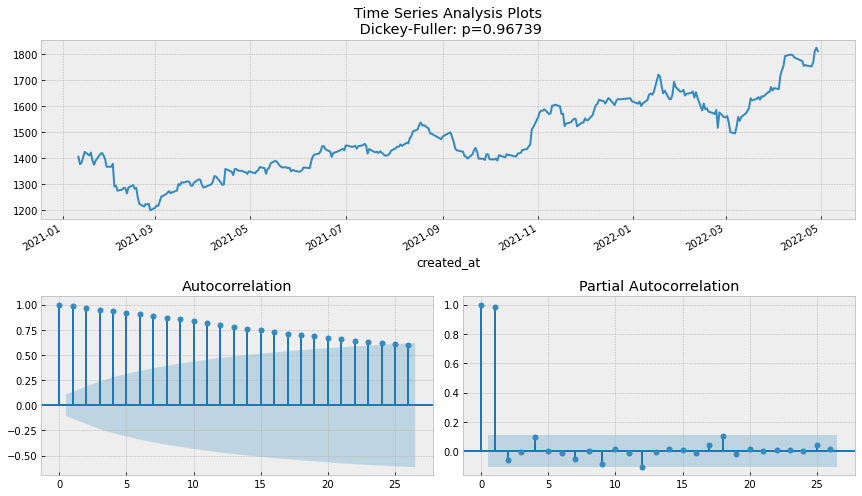

In [56]:
stationary_plot(merged["Close"])

### Testing without sentiment Variable.

In [57]:
stock_data_only = merged.drop(['sentiment'], axis=1)
stock_data_only.head()

,Open,High,Low,Close,Adj Close,Volume,trend,future_trend,sma_5,ema_5
created_at,,,,,,,,,,
2021-01-11,1415.538940,1423.396362,1401.033081,1405.264038,1258.198608,7629132,Negative,Positive,1403.491040,1406.583328
2021-01-12,1405.666870,1409.293457,1377.057983,1377.057983,1232.944458,9750633,Negative,Negative,1407.319018,1406.252729
2021-01-13,1370.207886,1388.541870,1370.207886,1382.699219,1237.995483,12758771,Positive,Negative,1405.626660,1399.503295
2021-01-14,1380.684448,1406.875854,1375.446167,1403.652222,1256.755615,18404664,Positive,Negative,1398.413989,1395.853878
2021-01-15,1395.996338,1425.401123,1390.355103,1424.000854,1274.974731,8084203,Positive,Positive,1397.487207,1397.466052


In [58]:
training_set = stock_data_only[:-test_size]
testing_set = stock_data_only[-test_size:]
print('There are {} training samples and {} test samples.'.format(len(df_train), len(df_test)))

There are 220 training samples and 110 test samples.


In [59]:
training_set.head()

,Open,High,Low,Close,Adj Close,Volume,trend,future_trend,sma_5,ema_5
created_at,,,,,,,,,,
2021-01-11,1415.538940,1423.396362,1401.033081,1405.264038,1258.198608,7629132,Negative,Positive,1403.491040,1406.583328
2021-01-12,1405.666870,1409.293457,1377.057983,1377.057983,1232.944458,9750633,Negative,Negative,1407.319018,1406.252729
2021-01-13,1370.207886,1388.541870,1370.207886,1382.699219,1237.995483,12758771,Positive,Negative,1405.626660,1399.503295
2021-01-14,1380.684448,1406.875854,1375.446167,1403.652222,1256.755615,18404664,Positive,Negative,1398.413989,1395.853878
2021-01-15,1395.996338,1425.401123,1390.355103,1424.000854,1274.974731,8084203,Positive,Positive,1397.487207,1397.466052


In [60]:
train_set, test_set = get_dummies(training_set, testing_set, 'trend')
train_set.head()

,Open,High,Low,Close,Adj Close,Volume,trend,future_trend,sma_5,ema_5,Neutral,Positive
created_at,,,,,,,,,,,,
2021-01-11,1415.538940,1423.396362,1401.033081,1405.264038,1258.198608,7629132,Negative,Positive,1403.491040,1406.583328,1.0,0.0
2021-01-12,1405.666870,1409.293457,1377.057983,1377.057983,1232.944458,9750633,Negative,Negative,1407.319018,1406.252729,1.0,0.0
2021-01-13,1370.207886,1388.541870,1370.207886,1382.699219,1237.995483,12758771,Positive,Negative,1405.626660,1399.503295,0.0,0.0
2021-01-14,1380.684448,1406.875854,1375.446167,1403.652222,1256.755615,18404664,Positive,Negative,1398.413989,1395.853878,0.0,0.0
2021-01-15,1395.996338,1425.401123,1390.355103,1424.000854,1274.974731,8084203,Positive,Positive,1397.487207,1397.466052,0.0,0.0


In [61]:
train_set.head()

,Open,High,Low,Close,Adj Close,Volume,trend,future_trend,sma_5,ema_5,Neutral,Positive
created_at,,,,,,,,,,,,
2021-01-11,1415.538940,1423.396362,1401.033081,1405.264038,1258.198608,7629132,Negative,Positive,1403.491040,1406.583328,1.0,0.0
2021-01-12,1405.666870,1409.293457,1377.057983,1377.057983,1232.944458,9750633,Negative,Negative,1407.319018,1406.252729,1.0,0.0
2021-01-13,1370.207886,1388.541870,1370.207886,1382.699219,1237.995483,12758771,Positive,Negative,1405.626660,1399.503295,0.0,0.0
2021-01-14,1380.684448,1406.875854,1375.446167,1403.652222,1256.755615,18404664,Positive,Negative,1398.413989,1395.853878,0.0,0.0
2021-01-15,1395.996338,1425.401123,1390.355103,1424.000854,1274.974731,8084203,Positive,Positive,1397.487207,1397.466052,0.0,0.0


In [62]:
train_set.drop(['trend'], axis=1, inplace=True)
test_set.drop(['trend'], axis=1, inplace=True)

In [63]:
train_set.head()

,Open,High,Low,Close,Adj Close,Volume,future_trend,sma_5,ema_5,Neutral,Positive
created_at,,,,,,,,,,,
2021-01-11,1415.538940,1423.396362,1401.033081,1405.264038,1258.198608,7629132,Positive,1403.491040,1406.583328,1.0,0.0
2021-01-12,1405.666870,1409.293457,1377.057983,1377.057983,1232.944458,9750633,Negative,1407.319018,1406.252729,1.0,0.0
2021-01-13,1370.207886,1388.541870,1370.207886,1382.699219,1237.995483,12758771,Negative,1405.626660,1399.503295,0.0,0.0
2021-01-14,1380.684448,1406.875854,1375.446167,1403.652222,1256.755615,18404664,Negative,1398.413989,1395.853878,0.0,0.0
2021-01-15,1395.996338,1425.401123,1390.355103,1424.000854,1274.974731,8084203,Positive,1397.487207,1397.466052,0.0,0.0


Feature Scaling

In [64]:
training_target = train_set["future_trend"].values
training_predictors = train_set.drop("future_trend", axis=1)
scaled_vals = scaler.fit_transform(training_predictors)
train_set = pd.DataFrame(scaled_vals, columns=training_predictors.columns)

# Put non-scaled target variable back into the dataframe
train_set['future_trend'] = trainset_target

# inspect the data
train_set.head()

,Open,High,Low,Close,Adj Close,Volume,sma_5,ema_5,Neutral,Positive,future_trend
0,0.243205,0.192014,0.210609,0.109349,-0.379757,-0.248521,0.114636,0.194885,1.126073,-0.095783,Positive
1,0.128392,0.025256,-0.069017,-0.216844,-0.638936,0.217608,0.160537,0.190590,1.126073,-0.095783,Negative
2,-0.283999,-0.220119,-0.148912,-0.151605,-0.587098,0.878545,0.140244,0.102902,-0.888042,-0.095783,Negative
3,-0.162155,-0.003331,-0.087816,0.090709,-0.394566,2.119040,0.053757,0.055489,-0.888042,-0.095783,Negative
4,0.015923,0.215719,0.086070,0.326034,-0.207587,-0.148534,0.042644,0.076435,-0.888042,-0.095783,Positive


In [65]:
testing_target = test_set["future_trend"].values
testing_predictors = test_set.drop("future_trend", axis=1)
scaled_vals = scaler.fit_transform(testing_predictors)
test_set = pd.DataFrame(scaled_vals, columns=testing_predictors.columns)

# Put non-scaled target variable back into the dataframe
test_set['future_trend'] = testing_target

# inspect the data
test_set.head()

,Open,High,Low,Close,Adj Close,Volume,sma_5,ema_5,Neutral,Positive,future_trend
0,-1.224473,-1.360030,-1.196127,-1.285150,-1.331686,-1.119004,-0.993220,-1.070999,1.224745,-0.095783,Negative
1,-1.313309,-1.238837,-1.304911,-1.188912,-1.243414,-0.728940,-1.172568,-1.130705,-0.816497,-0.095783,Negative
2,-1.167940,-1.155349,-1.017757,-1.106040,-1.167400,-0.895541,-1.244659,-1.160073,-0.816497,-0.095783,Negative
3,-1.062951,-1.201132,-0.972187,-1.100691,-1.162493,-1.030423,-1.301512,-1.166989,-0.816497,10.440307,Positive
4,-1.439833,-1.443520,-1.382737,-1.490993,-1.520494,-0.024711,-1.219457,-1.171620,1.224745,-0.095783,Negative


In [66]:
Xtrain = train_set.drop('future_trend', axis=1)
ytrain = train_set['future_trend'].copy()

#### Random Forest Classifier

In [67]:
rf = RandomForestClassifier(random_state=7)

# specify the hyperparameters and their values
# 4 x 3 x 2 = 24 combinations in the grid
param_grid = {
    'n_estimators': [10, 100, 200, 1000],
    'max_depth': [3, 5, 15],
    'min_samples_split': [5, 10]
}

# we'll use 5-fold cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=10,
                           scoring='accuracy', 
                           return_train_score=True) 

start = time.time()
grid_search.fit(Xtrain, ytrain)
end = time.time() - start
print(f"Took {end} seconds")

Took 115.39645195007324 seconds


In [68]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=10,
                       random_state=7)

In [69]:
grid_search.best_score_

0.5409090909090908

In [70]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)
feature_importances = grid_search.best_estimator_.feature_importances_

In [71]:
for k, v in sorted(zip(feature_importances, Xtrain.columns), reverse=True):
    print(f"{v}: {k}")

ema_5: 0.16176945218694544
sma_5: 0.14388267373126598
Adj Close: 0.13575839093418976
Close: 0.13541784131367912
High: 0.12253820504032117
Open: 0.11363080973494524
Volume: 0.09656123270407294
Low: 0.07256014226803402
Neutral: 0.016077614575618654
Positive: 0.0018036375109276499


In [72]:
# Save Models
if not os.path.exists("test_models"):
    os.makedirs("test_models")
    
dump(grid_search.best_estimator_, 'test_models/gsk-rftest-clf.joblib')

['test_models/gsk-rftest-clf.joblib']

#### Support Vector Classifier.

In [73]:
svc = SVC(random_state=7, kernel='rbf')

# specify the hyperparameters and their values
# 5 x 3 = 15 combinations in the grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ["scale", "auto", 0.1],
}

# we'll use 10-fold cross-validation
grid_search = GridSearchCV(svc, param_grid, cv=10,
                           scoring='accuracy', 
                           return_train_score=True) 

start = time.time()
grid_search.fit(Xtrain, ytrain)
end = time.time() - start
print(f"Took {end} seconds")

Took 15.773446798324585 seconds


In [74]:
grid_search.best_estimator_

SVC(C=10, gamma='auto', random_state=7)

In [75]:
grid_search.best_score_

0.7227272727272729

In [76]:
cv_results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score']]
cv_results["diff, %"] = 100*(cv_results["mean_train_score"]-cv_results["mean_test_score"]
                                                     )/cv_results["mean_train_score"]

pd.set_option('display.max_colwidth', 100)
cv_results.sort_values('mean_test_score', ascending=False)

,params,mean_train_score,mean_test_score,"diff, %"
10,"{'C': 10, 'gamma': 'auto'}",0.890404,0.722727,1.883154e+01
11,"{'C': 10, 'gamma': 0.1}",0.890404,0.722727,1.883154e+01
9,"{'C': 10, 'gamma': 'scale'}",0.888889,0.718182,1.920455e+01
13,"{'C': 100, 'gamma': 'auto'}",0.931313,0.686364,2.630152e+01
14,"{'C': 100, 'gamma': 0.1}",0.931313,0.686364,2.630152e+01
12,"{'C': 100, 'gamma': 'scale'}",0.933333,0.668182,2.840909e+01
6,"{'C': 1, 'gamma': 'scale'}",0.784343,0.600000,2.350290e+01
7,"{'C': 1, 'gamma': 'auto'}",0.785859,0.600000,2.365039e+01
8,"{'C': 1, 'gamma': 0.1}",0.785859,0.600000,2.365039e+01
0,"{'C': 0.01, 'gamma': 'scale'}",0.563636,0.563636,3.939501e-14


In [77]:
# Save Model
if not os.path.exists("test_models"):
    os.makedirs("test_models")
    
dump(grid_search.best_estimator_, 'test_models/gsk-svctest-rbf-clf.joblib')

['test_models/gsk-svctest-rbf-clf.joblib']

### Testing the models.

In [78]:
best_svc_test = load("test_models/gsk-svctest-rbf-clf.joblib")
best_rf_test = load("test_models/gsk-rftest-clf.joblib")

In [79]:
Xtest = test_set.drop('future_trend', axis=1)
ytest = test_set['future_trend'].copy()

In [80]:
predicted = best_svc_test.predict(Xtest)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(ytest, predicted, average="macro")
print("SVM:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

SVM:
Precision: 0.8230309072781654
Recall: 0.8301630434782609
F score: 0.8248260833123795


In [81]:
accuracy_score(ytest, predicted)

0.8272727272727273

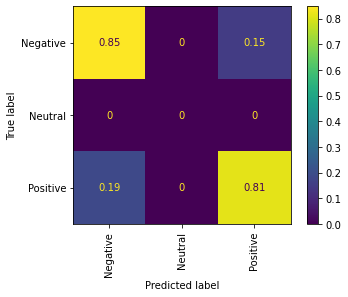

In [82]:
ConfusionMatrixDisplay.from_predictions(ytest, predicted, labels=best_svc_test.classes_, 
                                        xticks_rotation="vertical", normalize="true")

In [83]:
rf_predicted = best_rf_test.predict(Xtest)

# micro-averaged precision, recall and f-score
p, r, f, s = precision_recall_fscore_support(ytest, rf_predicted, average="macro")
print("Random Forest:")
print(f"Precision: {p}")
print(f"Recall: {r}")
print(f"F score: {f}")

Random Forest:
Precision: 0.7758152173913043
Recall: 0.7758152173913043
F score: 0.7758152173913042


In [84]:
accuracy_score(ytest, rf_predicted)

0.7818181818181819

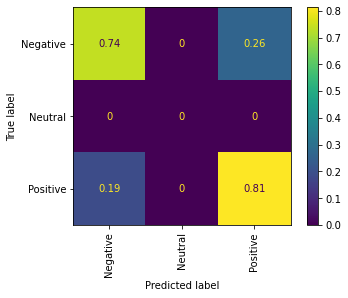

In [85]:
ConfusionMatrixDisplay.from_predictions(ytest, rf_predicted, labels=best_svc_test.classes_, 
                                        xticks_rotation="vertical", normalize="true")